# CLASSIFY IMAGES

In [22]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.utils import imageutils as iu
import geomapi.tools as tl

In [23]:
print(tf. __version__) 

2.10.0


In [24]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload 2

# USER INPUT

In [49]:
projectPath= os.path.join("D:\\Data\\2023-01 Colosseum")
sessionPath = os.path.join(projectPath,"Research")

#PCD
pcdGraphPath=os.path.join(sessionPath,"PCD","pcdGraph.ttl")
clusteredPcdGraphPath=os.path.join(sessionPath,"PCD","clusteredPcdGraph.ttl") #! temporary

#Images
imgGraphPath=os.path.join(sessionPath,"IMG","imgGraph.ttl")
tempfolder=pathlib.Path(os.path.join(sessionPath,'IMG_training_224','temp'))
modelPath=os.path.join(sessionPath,"IMG_training_224","Model_MobileNetV2_1_model")
batch_size = 32 #! same as model
pixelRange=224
class_names=[0.0,1.0,4.0]
# colors=[ut.random_color(255) for i in range(len(class_names))]
colors=[(255,0,0),(0,255,0),(0,0,255)]
materialClassificationGraphPath=os.path.join(sessionPath,"IMG_training_224","materialClassificationGraph.ttl")

# IMPORT RDF graphs 

Import the point cloud and images

In [27]:
pcdNode=tl.graph_path_to_nodes(graphPath=pcdGraphPath,getResource=True)[0]
print(str(len(ut.item_to_list(pcdNode))) + ' pcdNode')

# clusteredpcdNodes=tl.graph_path_to_nodes(graphPath=clusteredPcdGraphPath,getResource=True) #! temporary
# clusteredpcdNodes=[n for n in clusteredpcdNodes if n.resource]
# print(str(len(clusteredpcdNodes)) + ' clusteredpcdNodes')

imgNodes=tl.graph_path_to_nodes(graphPath=imgGraphPath,getResource=True,getMetaData=False)
imgNodes=[n for n in imgNodes if n.resource is not None]
print(str(len(imgNodes)) + ' imgNodes')

1 pcdNode
44 imgNodes


# LOAD AND PREPARE IMAGES

Split original images into regions and generate rays.

In [28]:
points=[]
imgTrainingNodes=[]
for n in imgNodes:
    imgList,roiList=iu.subdivide_image(n.resource,width=pixelRange,height=pixelRange,includeLast=False)
    imagePoints=np.vstack([np.array([sum(x[:2])/2,sum(x[2:4])/2]) for x in roiList])
    rays=n.create_rays(imagePoints)
    #create a new list of imageNodes
    nodeList=[]
    for img,roi,ray in zip(imgList,roiList,rays):
        nodeList.append(ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi,
                                ray=ray))                    
    #add to nodelist   
    imgTrainingNodes.extend(nodeList) 
print(len(imgTrainingNodes))

8228


(optionally) write resources to file

In [29]:

os.mkdir(tempfolder) if not os.path.exists(tempfolder) else None                   
temp=os.path.join(tempfolder,'0.0')
os.mkdir(temp) if not os.path.exists(temp) else None                   

for n in imgTrainingNodes:
    path=os.path.join(temp,n.name+'.png')
    cv2.imwrite(path, n.resource)

Create keras dataset(this takes 5min for 4000 images, consider buffering them on drive and importing them)

In [9]:
images=[n.resource for n in imgTrainingNodes]
dataset = tf.data.Dataset.from_tensor_slices(images).batch(batch_size)

TypeError: Invalid shape (32, 224, 224, 3) for image data

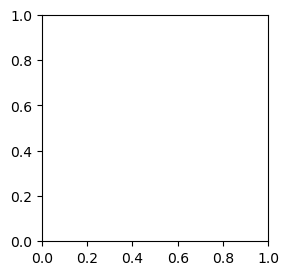

In [10]:
plt.figure(figsize=(10, 10))
for images in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## (alternatively), LOAD IMAGES from drive

In [30]:
dataset = tf.keras.utils.image_dataset_from_directory(
  tempfolder,
  labels='inferred',
  image_size=(pixelRange, pixelRange),
  batch_size=batch_size,
  shuffle=False)

#buffer for data performance
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

Found 8228 files belonging to 1 classes.


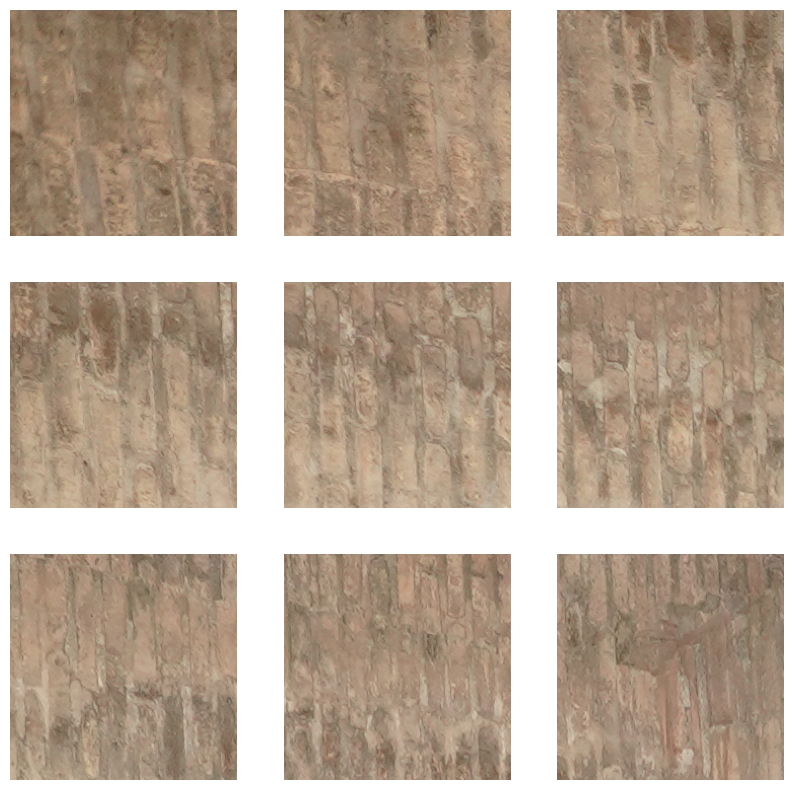

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# LOAD MATERIAL CLASSIFICATION MODEL

This model only classifies the label. Instead, we want to see the probability for each class.

In [32]:
model = tf.keras.models.load_model(modelPath)

In [14]:
# loss0, accuracy0 = model.evaluate(dataset)

(optional) Adapt model last layers

In [103]:
# #remove last layer of the model
# x = model.layers[-2].output 

# #create dense layer with nodes equal to the number of classes.
# prediction_layer = tf.keras.layers.Dense(len(classes)) 
# outputs = prediction_layer(x)

# #add new layer to the model
# model = tf.keras.Model(inputs = model.input, outputs = outputs)

# #use Softmax layer to translate scores to probabilities per class
# probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])

# #predict the results
# predictions = probability_model.predict(dataset)
# predictions

117/117 [==============================] - 14s 107ms/step


array([[0.0418802 , 0.9322153 , 0.02590458],
       [0.82566017, 0.16293746, 0.01140236],
       [0.86371017, 0.12286089, 0.01342899],
       ...,
       [0.24720843, 0.6642045 , 0.08858706],
       [0.30046138, 0.6797758 , 0.01976289],
       [0.06972137, 0.50318426, 0.4270944 ]], dtype=float32)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

(optional) applying argmax to these probabilities still gives the same result.

In [50]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(dataset)
print('Predictions probabilities:\n', predictions)

predicted_id = tf.math.argmax(predictions, axis=-1).numpy().astype(np.int32)
class_names=np.array(class_names)
predicted_id=class_names[predicted_id]
print('Predictions:\n', predicted_id)


258/258 [==============================] - 29s 109ms/step
Predictions probabilities:
 [[0.79759127 0.20016281 0.00224592]
 [0.79286504 0.20455803 0.0025769 ]
 [0.6582962  0.33676293 0.0049409 ]
 ...
 [0.02507827 0.971817   0.0031047 ]
 [0.04742938 0.00128311 0.95128745]
 [0.01236777 0.00190527 0.9857269 ]]
Predictions:
 [0. 0. 0. ... 1. 4. 4.]


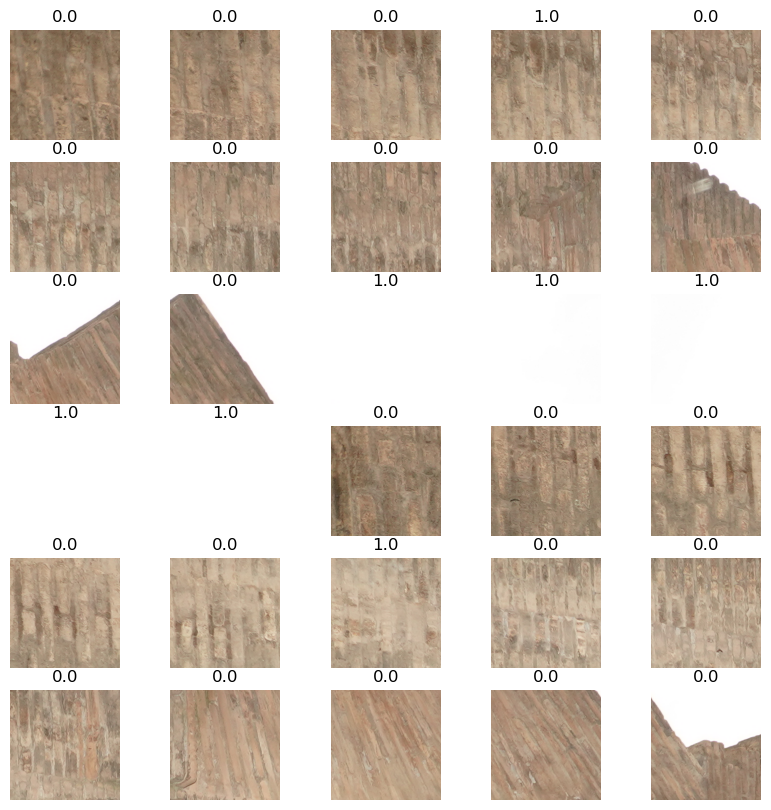

In [51]:
image_batch,_= dataset.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8")) #
  plt.title(predicted_id[i])
  plt.axis("off")

# ASSIGN AND EXPORT RESULTS

In [52]:
for n,y in zip(imgTrainingNodes,predicted_id):
    n.materialPrediction=y

(optional) read graph with results

In [21]:
imgTrainingNodes=tl.graph_path_to_nodes(graphPath=materialClassificationGraphPath,getResource=False,getMetaData=False)
print(str(len(imgTrainingNodes)) + ' imgTrainingNodes')

ValueError: No valid graphPath (only .ttl).

compile results for entire image

In [69]:
import copy

images=[]
for n in imgNodes:
    image=copy.deepcopy(n.resource)
    # test=imgTrainingNodes[0].isDerivedFrom
    # test2=n.subject
    # select nodes
    nodeList=[tn for tn in imgTrainingNodes if tn.isDerivedFrom ==n.subject]
    #create mask from roi
    for i,c in enumerate(class_names):
        
        # test3=np.argmax(nodeList[0].materialPrediction)
        roiList= [t.roi for t in nodeList if t.materialPrediction==c]
        if len(roiList) >0:
            for roi in roiList:
                roi=image[roi[0]:roi[1],roi[2]:roi[3]] 
                roi[:,:,:]=colors[i]
    images.append(image)   
    # result = cv2.add(image_masked, image2_masked)


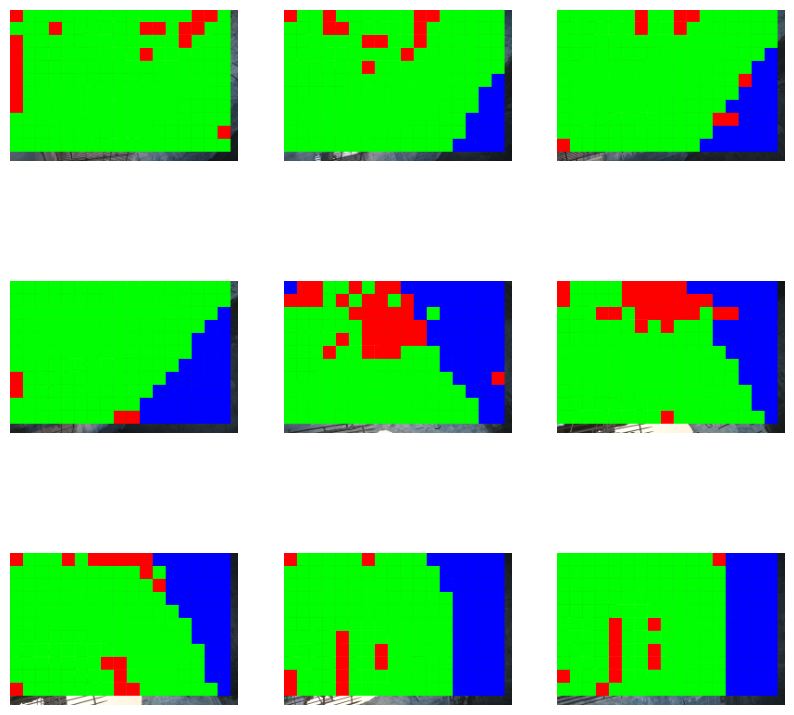

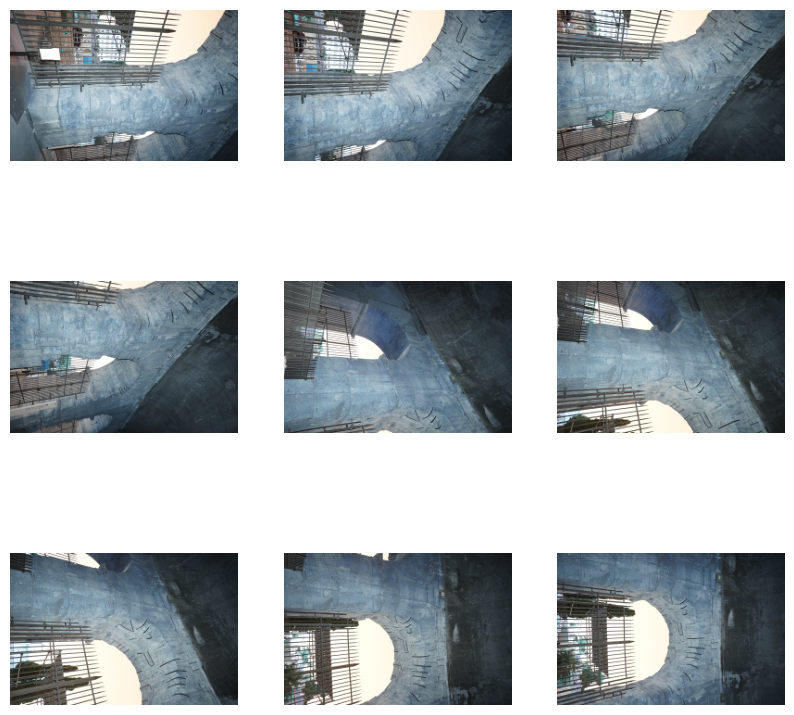

In [88]:
import math
n=[30,39]
plt.figure(figsize=(10, 10))
# for img in [n.resource for n in imgNodes]:
for i,img in enumerate(images[n[0]:n[1]]):
    ax = plt.subplot(3, 3, i+1 )
    # plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.imshow(iu.image_resize(img,scale=1/16))
    plt.axis("off")
plt.figure(figsize=(10, 10))
# for img in [n.resource for n in imgNodes]:
for i,img in enumerate([t for t in imgNodes[n[0]:n[1]]]):
    ax = plt.subplot(3, 3, i+1 )
    # plt.imshow(cv2.resize(img, (math.ceil(img.shape[1]/16),math.ceil(img.shape[0]/16))))
    plt.imshow(iu.image_resize(img.resource,scale=1/16))
    plt.axis("off")

In [56]:
{key:value for key, value in imgTrainingNodes[2].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 224,
 'imageHeight': 224,
 'focalLength35mm': None,
 '_subject': rdflib.term.URIRef('file:///f55d2367-a148-11ed-90f1-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': 'f55d2367-a148-11ed-90f1-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[102, 123, 154],
         [ 97, 118, 149],
         [110, 131, 163],
         ...,
         [130, 151, 172],
         [130, 151, 173],
         [127, 147, 172]],
 
        [[ 95, 117, 145],
         [ 96, 118, 146],
         [107, 128, 159],
         ...,
         [133, 154, 175],
         [127, 148, 169],
         [124, 145, 167]],
 
        [[108, 132, 156],
         [ 91, 115, 139],
         [ 91, 114, 140],
         ...,
         [133, 155, 173],
         [125, 147, 165],
         [123, 145, 163]],
 
        ...,
 
        [[118, 144, 174],
         [119, 145, 175],
         [120, 145, 177],
         ...,
         [146, 174,

In [89]:
graph=tl.nodes_to_graph(imgTrainingNodes,materialClassificationGraphPath,save=True)
print (str(len(imgTrainingNodes))+' Nodes succesfully serialized in: '+materialClassificationGraphPath)

8228 Nodes succesfully serialized in: D:\Data\2023-01 Colosseum\Research\IMG_training_224\materialClassificationGraph.ttl


(optional) destroy temp folder